In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action="ignore", category=FutureWarning)

## Config

In [ ]:
#訓練資料檔案位置
inputData = "./2022-train-v2.xlsx" 

#標準化模型儲存資料夾位置
stdModelFile = "./output/model/"

#訓練模型儲存資料夾位置
pklFile = "./output/model/"

#模型blending權重檔案
blendingWeightFile = pklFile+"blending_weight.txt"

## Input Data

In [3]:
trainData = pd.read_excel(inputData)

## Data Process

In [4]:
procTrainData = trainData.copy()

In [5]:
#找出空值
missing = trainData.isnull().sum()
missing.sort_values(ascending=False, inplace=True)
missingCount = pd.DataFrame({"Column Name":missing.index,"Missing Count":missing.values})
missingCount["Percentage(%)"] = missingCount["Missing Count"].apply(lambda x: x/trainData.shape[0])
missingCount.head(10)

,Column Name,Missing Count,Percentage(%)
0,clean_ph5,286,0.450394
1,clean_ph7,286,0.450394
2,clean_ph4,286,0.450394
3,painting_g9_act_t_air,0,0.000000
4,painting_g9_act_hvv,0,0.000000
5,painting_g9_act_hvc,0,0.000000
6,painting_g10_act_a_air,0,0.000000
7,painting_g10_act_f_air,0,0.000000
8,painting_g10_act_t_air,0,0.000000
9,painting_g10_act_hvv,0,0.000000


In [6]:
#刪除有缺失值欄位
dropCol = list(missingCount[missingCount["Missing Count"]>0]["Column Name"])
print(dropCol)
procTrainData = procTrainData.drop(dropCol, axis=1)

['clean_ph5', 'clean_ph7', 'clean_ph4']


In [7]:
#刪除資料變化較低(標準差std<0.01)之欄位 
dropCol = []
for i in procTrainData.columns:
    tempData =procTrainData.loc[:,i]
    n=1.5
    IOR = np.percentile(tempData,85) - np.percentile(tempData,15)
    tempData =tempData[tempData <np.percentile(tempData,75)+n*IOR]
    if len(tempData)>0:
        tempData =tempData[tempData <np.percentile(tempData,25)-n*IOR]
        if np.std(tempData)<0.01:
            dropCol.append(i)
    else:
        dropCol.append(i)

print(dropCol)

['clean_pressure11', 'clean_pressure21', 'clean_pressure23', 'clean_pressure72', 'clean_pressure101', 'painting_g6_act_a_air', 'painting_g6_act_f_air', 'painting_g6_act_t_air', 'painting_g6_act_hvv', 'painting_g6_act_hvc', 'painting_g12_act_a_air', 'painting_g12_act_f_air', 'painting_g12_act_t_air', 'painting_g12_act_hvv', 'painting_g12_act_hvc', 'env_rpi09_hum', 'env_rpi09_lux', 'env_rpi09_temp']


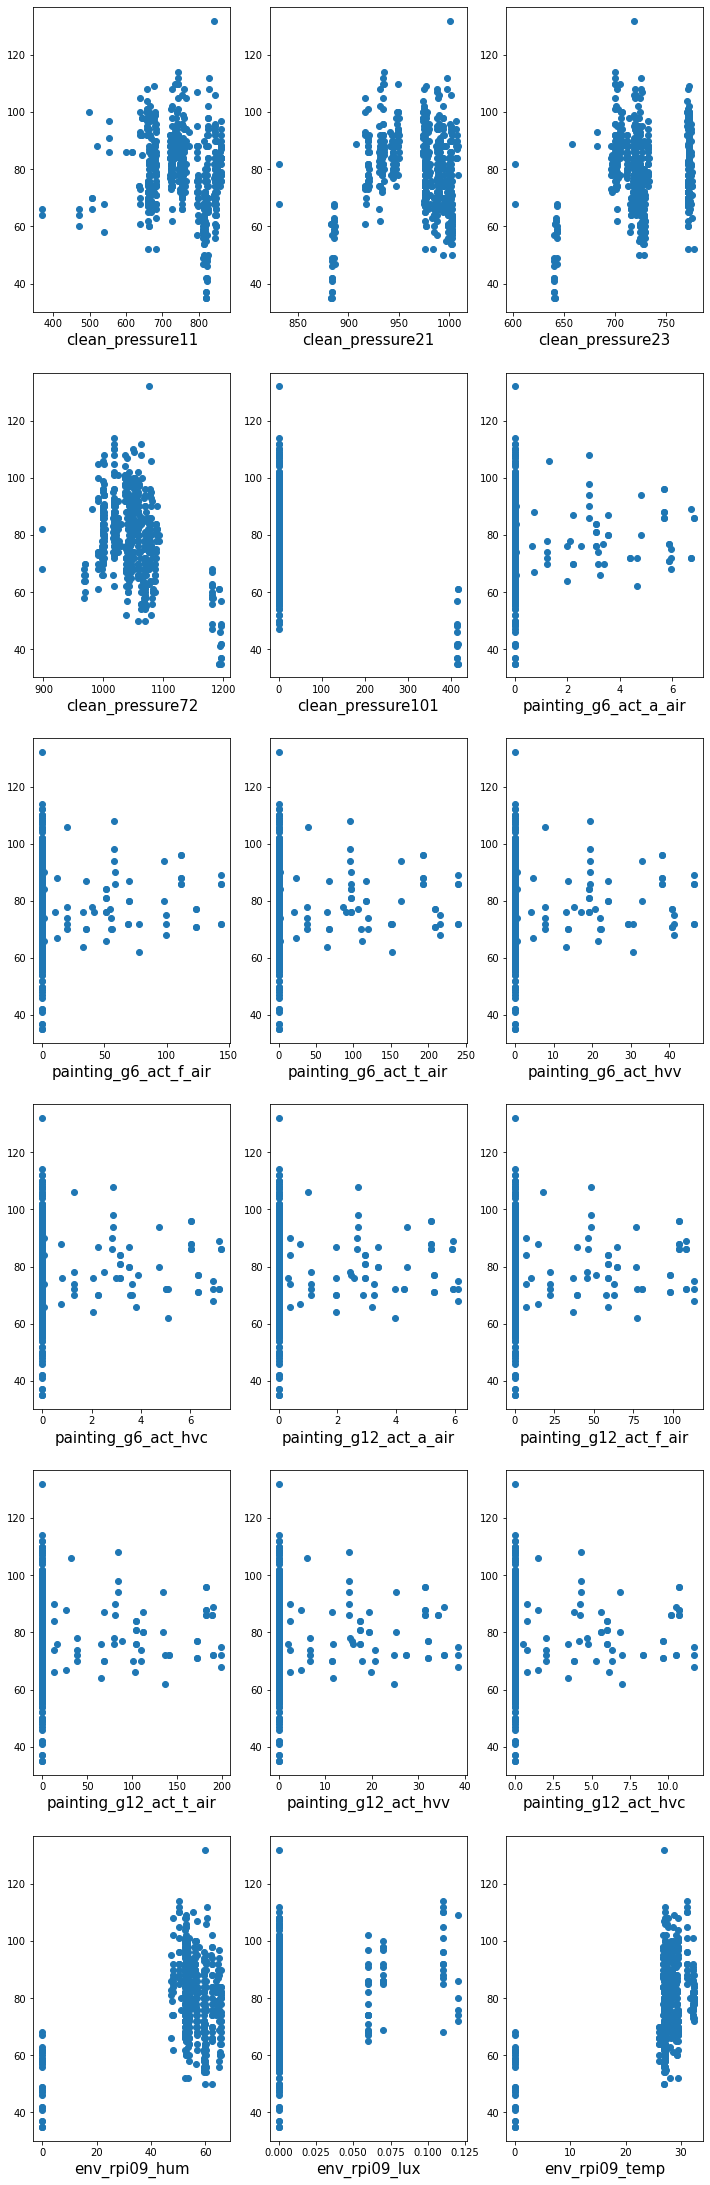

In [8]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(12,120))
for i, feature in enumerate(list(procTrainData[dropCol]),1):
    plt.subplot(len(list(dropCol)), 3, i)
    plt.scatter(x=feature, y = "sensor_point5_i_value", data=procTrainData)
    plt.xlabel(feature, size =15)
plt.show()

In [8]:
procTrainData = procTrainData.drop(dropCol, axis=1)

In [9]:
#刪除共線性(相關係數>0.95)之欄位
Xcorr = procTrainData.corr()
recordrows = []
result = {}
for index, row in Xcorr.iterrows():
    if index not in recordrows:
        for i, v in row.items():
            if i not in result and i != index:
                if v>0.95:
                    if index not in result:
                        if i not in recordrows:
                            result[index]=[i]
                            recordrows.append(i)
                    else:
                        if i not in recordrows:
                            result[index].append(i)
                            recordrows.append(i)
                            
dropCol=[]
for key in result:
    dropCol+=result[key]
print(dropCol)

procTrainData = procTrainData.drop(dropCol, axis=1)

['clean_pressure92', 'clean_pressure71', 'oven_pb2', 'oven_a2', 'oven_b2', 'oven_b3', 'painting_g1_act_f_air', 'painting_g1_act_t_air', 'painting_g1_act_hvv', 'painting_g1_act_hvc', 'painting_g7_act_a_air', 'painting_g7_act_f_air', 'painting_g7_act_t_air', 'painting_g7_act_hvv', 'painting_g2_act_t_air', 'painting_g8_act_a_air', 'painting_g8_act_t_air', 'painting_g3_act_t_air', 'painting_g9_act_t_air', 'painting_g9_act_f_air', 'painting_g4_act_f_air', 'painting_g4_act_t_air', 'painting_g4_act_hvv', 'painting_g10_act_a_air', 'painting_g10_act_f_air', 'painting_g10_act_t_air', 'painting_g10_act_hvv', 'painting_g5_act_f_air', 'painting_g5_act_t_air', 'painting_g5_act_hvv', 'painting_g11_act_f_air', 'painting_g11_act_t_air', 'painting_g11_act_hvv', 'env_rpi05_pm10', 'env_rpi05_pm25', 'env_rpi07_pm10', 'env_rpi07_pm25', 'env_rpi09_pm10', 'env_rpi09_pm25', 'env_rpi14_pm10', 'env_rpi14_pm25', 'env_rpi15_pm10', 'env_rpi15_pm25']


In [10]:
totalDropCol =['clean_ph5', 'clean_ph7', 'clean_ph4','clean_pressure11', 'clean_pressure21', 'clean_pressure23', 'clean_pressure72', 'clean_pressure101', 'painting_g6_act_a_air', 'painting_g6_act_f_air', 'painting_g6_act_t_air', 'painting_g6_act_hvv', 'painting_g6_act_hvc', 'painting_g12_act_a_air', 'painting_g12_act_f_air', 'painting_g12_act_t_air', 'painting_g12_act_hvv', 'painting_g12_act_hvc', 'env_rpi09_hum', 'env_rpi09_lux', 'env_rpi09_temp','clean_pressure92', 'clean_pressure71', 'oven_pb2', 'oven_a2', 'oven_b2', 'oven_b3', 'painting_g1_act_f_air', 'painting_g1_act_t_air', 'painting_g1_act_hvv', 'painting_g1_act_hvc', 'painting_g7_act_a_air', 'painting_g7_act_f_air', 'painting_g7_act_t_air', 'painting_g7_act_hvv', 'painting_g2_act_t_air', 'painting_g8_act_a_air', 'painting_g8_act_t_air', 'painting_g3_act_t_air', 'painting_g9_act_t_air', 'painting_g9_act_f_air', 'painting_g4_act_f_air', 'painting_g4_act_t_air', 'painting_g4_act_hvv', 'painting_g10_act_a_air', 'painting_g10_act_f_air', 'painting_g10_act_t_air', 'painting_g10_act_hvv', 'painting_g5_act_f_air', 'painting_g5_act_t_air', 'painting_g5_act_hvv', 'painting_g11_act_f_air', 'painting_g11_act_t_air', 'painting_g11_act_hvv', 'env_rpi05_pm10', 'env_rpi05_pm25', 'env_rpi07_pm10', 'env_rpi07_pm25', 'env_rpi09_pm10', 'env_rpi09_pm25', 'env_rpi14_pm10', 'env_rpi14_pm25', 'env_rpi15_pm10', 'env_rpi15_pm25']

## 標準化

In [11]:
from sklearn import preprocessing
import pickle

In [49]:
xCol = ["sensor_point5_i_value","sensor_point6_i_value","sensor_point7_i_value","sensor_point8_i_value","sensor_point9_i_value","sensor_point10_i_value"]
y = procTrainData.loc[:,xCol]
X = procTrainData.copy()
X = X.drop(xCol, axis=1)
scale = preprocessing.StandardScaler()
std = scale.fit(X)
X = std.transform(X)
with open(stdModelFile+"stdMode.pkl","wb") as file:
    pickle.dump(std,file)

## 建模: 預計採用blending作法，分別對各模型調參

In [48]:
import os
import math
import pickle
import numpy as np
from sklearn.model_selection import GridSearchCV

#初始化資料夾
pointArr = ["5","6","7","8","9","10"]
for i in pointArr:   
    pointStr = "point{}".format(i)
    file = pklFile+pointStr+"/"
    try:
        os.makedirs(file)
    except FileExistsError:
        print(pointStr+"目錄已存在")

- xgboost

In [21]:
from xgboost import XGBRegressor

In [24]:
RMSE = []
pointArr = ["5","6","7","8","9","10"]
param_dist = {
    
    "n_estimators":range(500,1000,100),
    "max_depth":range(4,7,1),
    "colsample_bytree":np.linspace(0.7,1,3)
}

modelname = "xgb.pkl"
for i in pointArr:
    
    pointStr = "point{}".format(i)
    xgb = XGBRegressor(eta=0.1, verbosity=0)
    grid = GridSearchCV(xgb, param_dist, cv=5, scoring="neg_mean_squared_error")
    
    grid.fit(X, y["sensor_{}_i_value".format(pointStr)])
    print("{} 最佳參數:{}".format(pointStr, grid.best_params_))
    filename = pklFile+pointStr+"/"+modelname
    with open(filename, "wb") as file:
        pickle.dump(grid.best_estimator_,file)
        
    RMSE.append(math.sqrt(abs(grid.best_score_)))

point5 最佳參數:{'colsample_bytree': 0.85, 'max_depth': 6, 'n_estimators': 500}
point6 最佳參數:{'colsample_bytree': 0.85, 'max_depth': 5, 'n_estimators': 500}
point7 最佳參數:{'colsample_bytree': 0.85, 'max_depth': 5, 'n_estimators': 500}
point8 最佳參數:{'colsample_bytree': 1.0, 'max_depth': 6, 'n_estimators': 600}
point9 最佳參數:{'colsample_bytree': 0.85, 'max_depth': 6, 'n_estimators': 800}
point10 最佳參數:{'colsample_bytree': 0.7, 'max_depth': 6, 'n_estimators': 900}


In [26]:
RMSE

[13.51934960437009,
 23.968385391926105,
 27.735341801934773,
 28.92534471709448,
 28.207856903492665,
 18.85552200501134]

- catboost

In [27]:
from catboost import CatBoostRegressor

In [28]:
RMSE = []
pointArr = ["5","6","7","8","9","10"]
param_dist = {
    
    "iterations":[100,150,200],
    "learning_rate":[0.03,0.1],
    "depth":[2,4,6,8],
    "l2_leaf_reg":[0.5,1,3]
}

modelname = "catb.pkl"
for i in pointArr:
    
    pointStr = "point{}".format(i)
    catb = CatBoostRegressor(random_state=42,loss_function ="RMSE",eval_metric="RMSE",silent=True)
    grid = GridSearchCV(catb, param_dist,  cv=5, scoring="neg_mean_squared_error")
    
    grid.fit(X, y["sensor_{}_i_value".format(pointStr)])
    print("{} 最佳參數:{}".format(pointStr, grid.best_params_))
    filename = pklFile+pointStr+"/"+modelname
    with open(filename, "wb") as file:
        pickle.dump(grid.best_estimator_,file)
        
    RMSE.append(math.sqrt(abs(grid.best_score_)))

point5 最佳參數:{'depth': 2, 'iterations': 150, 'l2_leaf_reg': 0.5, 'learning_rate': 0.1}
point6 最佳參數:{'depth': 6, 'iterations': 200, 'l2_leaf_reg': 0.5, 'learning_rate': 0.03}
point7 最佳參數:{'depth': 2, 'iterations': 100, 'l2_leaf_reg': 3, 'learning_rate': 0.1}
point8 最佳參數:{'depth': 4, 'iterations': 100, 'l2_leaf_reg': 0.5, 'learning_rate': 0.03}
point9 最佳參數:{'depth': 8, 'iterations': 150, 'l2_leaf_reg': 3, 'learning_rate': 0.03}
point10 最佳參數:{'depth': 8, 'iterations': 200, 'l2_leaf_reg': 3, 'learning_rate': 0.1}


In [29]:
RMSE

[12.991598443722769,
 23.482211555803705,
 24.876561430853762,
 24.82152231930653,
 22.499350070999643,
 17.286673204410988]

- GradientBoostingRegressor

In [14]:
from sklearn.ensemble import GradientBoostingRegressor

In [16]:
RMSE = []
pointArr = ["5","6","7","8","9","10"]
param_dist = {
    
    "n_estimators":[300,500,700,900],
    "max_depth":[4,6,8,10],
    "learning_rate":[0.02,0.03,0.04]
}

modelname = "gbr.pkl"
for i in pointArr:
    
    pointStr = "point{}".format(i)
    gbr = GradientBoostingRegressor()
    grid = GridSearchCV(gbr, param_dist,  cv=5, scoring="neg_mean_squared_error")
    
    grid.fit(X, y["sensor_{}_i_value".format(pointStr)])
    print("{} 最佳參數:{}".format(pointStr, grid.best_params_))
    filename = pklFile+pointStr+"/"+modelname
    with open(filename, "wb") as file:
        pickle.dump(grid.best_estimator_,file)
        
    RMSE.append(math.sqrt(abs(grid.best_score_)))

point5 最佳參數:{'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 300}
point6 最佳參數:{'learning_rate': 0.02, 'max_depth': 6, 'n_estimators': 500}
point7 最佳參數:{'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 300}
point8 最佳參數:{'learning_rate': 0.02, 'max_depth': 6, 'n_estimators': 300}
point9 最佳參數:{'learning_rate': 0.04, 'max_depth': 6, 'n_estimators': 900}
point10 最佳參數:{'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 300}


In [17]:
RMSE

[13.93907567360226,
 25.284332049606743,
 31.14900036281113,
 25.0551066671077,
 26.256073175711236,
 20.322341814121984]

- RandomForestRegressor

In [19]:
from sklearn.ensemble import RandomForestRegressor

In [20]:
RMSE = []
pointArr = ["5","6","7","8","9","10"]
param_dist = {
    
    "n_estimators":[50,100,150,200],
    "max_depth":[5,10,15],
    "max_features":["auto","log2","sqrt"],
}

modelname = "rfr.pkl"
for i in pointArr:
    
    pointStr = "point{}".format(i)
    rfr = RandomForestRegressor(random_state=42)
    grid = GridSearchCV(rfr, param_dist,  cv=5, scoring="neg_mean_squared_error")
    
    grid.fit(X, y["sensor_{}_i_value".format(pointStr)])
    print("{} 最佳參數:{}".format(pointStr, grid.best_params_))
    filename = pklFile+pointStr+"/"+modelname
    with open(filename, "wb") as file:
        pickle.dump(grid.best_estimator_,file)
        
    RMSE.append(math.sqrt(abs(grid.best_score_)))

point5 最佳參數:{'max_depth': 5, 'max_features': 'log2', 'n_estimators': 100}
point6 最佳參數:{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
point7 最佳參數:{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 50}
point8 最佳參數:{'max_depth': 5, 'max_features': 'auto', 'n_estimators': 50}
point9 最佳參數:{'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 50}
point10 最佳參數:{'max_depth': 15, 'max_features': 'log2', 'n_estimators': 100}


In [21]:
RMSE

[13.135394591645674,
 24.594331821697313,
 24.905071144505435,
 23.832461833208214,
 22.689539590414125,
 17.92646522517798]

- SVR

In [22]:
from sklearn.svm import SVR

In [23]:
RMSE = []
pointArr = ["5","6","7","8","9","10"]
param_dist = {
    
    "C":[1,5,10,50,100],
}

modelname = "svr.pkl"
for i in pointArr:
    
    pointStr = "point{}".format(i)
    svr = SVR(kernel='rbf', gamma=0.01)
    grid = GridSearchCV(svr, param_dist,  cv=5, scoring="neg_mean_squared_error")
    
    grid.fit(X, y["sensor_{}_i_value".format(pointStr)])
    print("{} 最佳參數:{}".format(pointStr, grid.best_params_))
    filename = pklFile+pointStr+"/"+modelname
    with open(filename, "wb") as file:
        pickle.dump(grid.best_estimator_,file)
        
    RMSE.append(math.sqrt(abs(grid.best_score_)))

point5 最佳參數:{'C': 1}
point6 最佳參數:{'C': 10}
point7 最佳參數:{'C': 10}
point8 最佳參數:{'C': 5}
point9 最佳參數:{'C': 50}
point10 最佳參數:{'C': 5}


In [24]:
RMSE

[13.342741794620112,
 25.76466125646817,
 26.35524590556489,
 25.806750505018737,
 22.116104258885894,
 17.51905177366181]

- knn

In [26]:
from sklearn.neighbors import KNeighborsRegressor

In [31]:
RMSE = []
pointArr = ["5","6","7","8","9","10"]
param_dist = {
    
}

modelname = "knn.pkl"
for i in pointArr:
    
    pointStr = "point{}".format(i)
    knn = KNeighborsRegressor()
    grid = GridSearchCV(knn, param_dist,  cv=5, scoring="neg_mean_squared_error")
    
    grid.fit(X, y["sensor_{}_i_value".format(pointStr)])
    print("{} 最佳參數:{}".format(pointStr, grid.best_params_))
    filename = pklFile+pointStr+"/"+modelname
    with open(filename, "wb") as file:
        pickle.dump(grid.best_estimator_,file)
        
    RMSE.append(math.sqrt(abs(grid.best_score_)))

point5 最佳參數:{}
point6 最佳參數:{}
point7 最佳參數:{}
point8 最佳參數:{}
point9 最佳參數:{}
point10 最佳參數:{}


In [32]:
RMSE

[15.305798396912497,
 35.65284938530634,
 31.670365193601146,
 24.700677411093995,
 22.619204438901445,
 18.84460281136512]

- Stacking model

In [28]:
from sklearn.ensemble import StackingRegressor
from sklearn.neural_network import MLPRegressor

In [29]:
RMSE = []
pointArr = ["5","6","7","8","9","10"]

modelname = "stk.pkl"
for i in pointArr:
    
    mlp = MLPRegressor(random_state=1000,activation ="relu",alpha=0.1, hidden_layer_sizes=(4,4),max_iter=2000)
    estimators = []
    pointStr = "point{}".format(i)
    estimatorsArr = ['xgb', 'svr','gbr', 'catb' , 'rfr' ,'knn']

    for i in estimatorsArr:
        filename = pklFile+pointStr+"/"+i+".pkl"
        with open(filename,"rb") as file:
            estimators.append((i,pickle.load(file)))
    
    stk = StackingRegressor(estimators = estimators, final_estimator = mlp)

    grid = GridSearchCV(stk, param_grid={},cv=5, scoring="neg_mean_squared_error")

    grid.fit(X,y["sensor_{}_i_value".format(pointStr)])
    print("{} 最佳參數:{}".format(pointStr, grid.best_params_))
    filename = pklFile+pointStr+"/"+modelname
    with open(filename, "wb") as file:
        pickle.dump(grid.best_estimator_,file)
        
    RMSE.append(math.sqrt(abs(grid.best_score_)))

point5 最佳參數:{}
point6 最佳參數:{}
point7 最佳參數:{}
point8 最佳參數:{}
point9 最佳參數:{}
point10 最佳參數:{}


In [30]:
RMSE

[13.600870612058458,
 27.554184074969648,
 28.071188575651814,
 25.863488586884472,
 26.32157069483927,
 19.092666428131828]

## 建模: blending

In [33]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [40]:
#採SLSQP求得各模型權重
estimatorsArr = ['xgb', 'svr','gbr', 'catb' , 'rfr' ,'knn','stk']
pointArr = ["5","6","7","8","9","10"]
result = {}
for i in pointArr:
    
    estimators = {}
    pointStr = "point{}".format(i)

    for i in estimatorsArr:
        filename = pklFile+pointStr+"/"+i+".pkl"
        with open(filename,"rb") as file:
            estimators[i] = pickle.load(file)

    models=list(estimators.values())
    predictions = []
    for model in models:
        predictions.append(model.predict(X))

    def mse_func(weights):
        #scipy minimize will pass the weights as a numpy array
        final_prediction = 0
        for weight, prediction in zip(weights, predictions):
            final_prediction += weight*prediction
        #return np.mean((y_test-final_prediction)**2)
        return np.sqrt(mean_squared_error(y["sensor_{}_i_value".format(pointStr)], final_prediction))

    starting_values = [0]*len(predictions)

    cons = ({'type':'ineq','fun':lambda w: 1-sum(w)})
    #our weights are bound between 0 and 1
    bounds = [(0.05,1)]*len(predictions)

    res = minimize(mse_func, starting_values, method='SLSQP', bounds=bounds, constraints=cons)

    print('Ensamble Score: {best_score}'.format(best_score=res['fun']))
    print('Best Weights: {weights}'.format(weights=res['x']))

    blend_wts = pd.DataFrame({'model': estimatorsArr, 'optimised_wts': list(res['x'])}, columns=['model', 'optimised_wts'])
    result[pointStr] = blend_wts.to_json(orient="records")

Ensamble Score: 5.615783918189824
Best Weights: [0.48885463 0.05       0.05       0.05       0.05       0.21755883
 0.09358653]
Ensamble Score: 9.080220251190699
Best Weights: [0.05       0.05       0.69990992 0.05000002 0.05009006 0.05
 0.05      ]
Ensamble Score: 11.766123738264332
Best Weights: [0.50759219 0.05000001 0.05       0.05       0.11333721 0.05
 0.17907059]
Ensamble Score: 11.165794459474519
Best Weights: [0.05011541 0.05       0.69985679 0.05002779 0.05       0.05
 0.05      ]
Ensamble Score: 9.71356287647252
Best Weights: [0.69974988 0.05       0.05       0.05       0.05025011 0.05
 0.05      ]
Ensamble Score: 8.558745309468584
Best Weights: [0.61896641 0.05000002 0.13094737 0.05008618 0.05       0.05
 0.05000001]


In [45]:
import json
filename = blendingWeightFile
with open(filename, "w") as file:
    file.write(json.dumps(result, indent=4))